# **Treinando Modelo**

In [ ]:
import kagglehub
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, applications, optimizers
import os

# Download dataset
path = kagglehub.dataset_download("kaggleashwin/vehicle-type-recognition")
dataset_path = os.path.join(path, "Dataset")

# Set Hiperparâmetros
batch_size = 32
img_size = (224, 224)
seed = 123

# Obter classes
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

class_names = raw_train_ds.class_names
print("Classes encontradas:", class_names)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3)
])

# Pré-processamento
def preprocess_data(image, label):
    image = data_augmentation(image)
    image = applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Recarregar os dados com label_mode='categorical'
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Aplicar pré-processamento
train_ds = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (applications.mobilenet_v2.preprocess_input(x), y),
                  num_parallel_calls=tf.data.AUTOTUNE)

# Cache e prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

# Modelo com Transfer Learning
base_model = applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    layers.Input(shape=img_size + (3,)),
    base_model,

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')  # Usamos class_names salvo anteriormente
])

# Compilação
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks_list = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

# Treinamento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks_list
)

# Avaliação
loss, acc = model.evaluate(val_ds)
print(f"\n✅ Accuracy de validação final: {acc:.2%}")

Found 400 files belonging to 4 classes.
Using 320 files for training.
Classes encontradas: ['Bus', 'Car', 'Truck', 'motorcycle']
Found 400 files belonging to 4 classes.
Using 320 files for training.
Found 400 files belonging to 4 classes.
Using 80 files for validation.
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.2129 - loss: 6.6409 - val_accuracy: 0.2625 - val_loss: 5.8177 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.3273 - loss: 6.1331 - val_accuracy: 0.3250 - val_loss: 5.5560 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4211 - loss: 5.9030 - val_accuracy: 0.4750 - val_loss: 5.3389 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4470 - loss: 5.6184 - val_accuracy: 0.5625 - val_loss: 5.1702 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4853 - loss: 5.5211 - val_accuracy: 0.6250 - val_l

# **Exportação do Modelo**

In [ ]:
model.save('vehicle_classifier.keras')

# **Teste com imagem externas**

In [ ]:
model = keras.models.load_model('vehicle_classifier.keras')

uploaded = files.upload()
file_name = list(uploaded.keys())[0]

img = image.load_img(file_name, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

predictions = model.predict(img_array)

predicted_class = np.argmax(predictions, axis=1)[0]

class_names = ['Ônibus', 'Carro', 'Caminhão', 'Moto']

print(f'A imagem foi classificada como: {class_names[predicted_class]}')


Saving caminhao 3.jpg to caminhao 3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
A imagem foi classificada como: Caminhão


# **Gráficos**

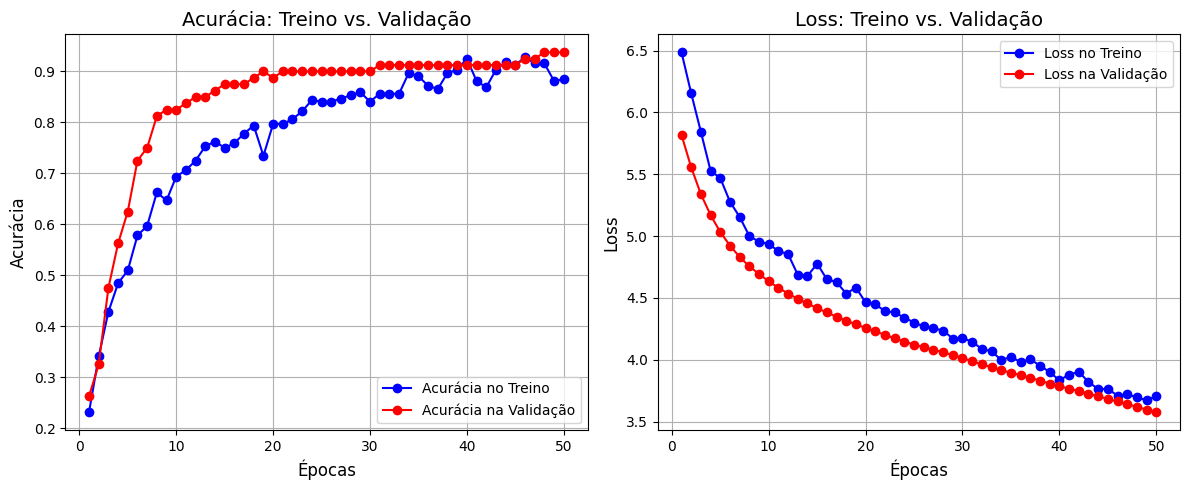

In [ ]:
import matplotlib.pyplot as plt

# Extrair os dados do treinamento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Acurácia
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Acurácia no Treino')
plt.plot(epochs, val_acc, 'ro-', label='Acurácia na Validação')
plt.title('Acurácia: Treino vs. Validação', fontsize=14)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Loss no Treino')
plt.plot(epochs, val_loss, 'ro-', label='Loss na Validação')
plt.title('Loss: Treino vs. Validação', fontsize=14)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()